In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [41]:
app_root = Path(os.getcwd())
train_path = app_root/'training'
img_class_path = train_path/'images/classes'

print(train_path.ls())
img_class_path.ls()

[PosixPath('/app/training/images')]


[PosixPath('/app/training/images/classes/coral'),
 PosixPath('/app/training/images/classes/king')]

In [42]:
for p in img_class_path.ls():
    verify_images(p, delete=True)

In [5]:
# Batch Size. Lower if you run out of memory. Larger images, bigger models and bigger batch sizes need more memory.
# bs = 64
bs = 16

In [43]:
# Seed numpy's PNRG explicitly so that the exact same validation set is created each time
np.random.seed(42)
data = ImageDataBunch.from_folder(train_path, train=img_class_path, valid_pct=0.2,
        ds_tfms=get_transforms(), size=299, num_workers=4, bs=bs).normalize(imagenet_stats)
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['coral', 'king'], 2, 341, 85)

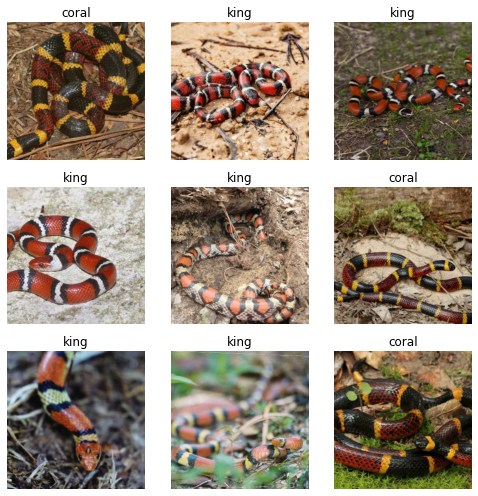

In [44]:
data.show_batch(rows=3, figsize=(7,7))

In [48]:
# Resnet 34
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

# OR Resnet 50. Model more memory so probably need to reduce the batch size.
# data.batch_size = bs // 2
# learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [49]:
learn.fit_one_cycle(4)
learn.save('stage-1')

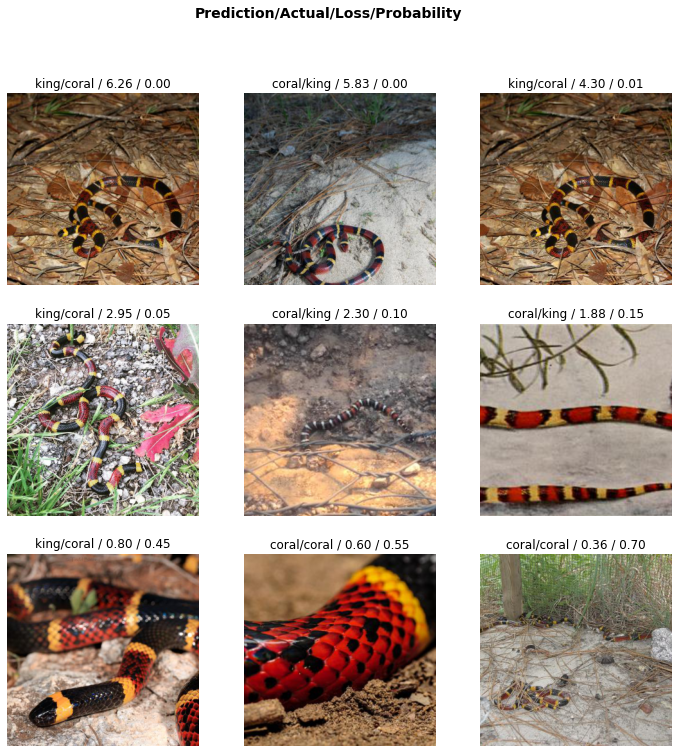

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
inter.plot_top_losses(9)

In [12]:
# Probably will want to reload and try several combinations of max_lr range and number of epochs.
# Re-load, learn, train, note the results. Then repeat with a variation.

# learn.load('stage-1')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


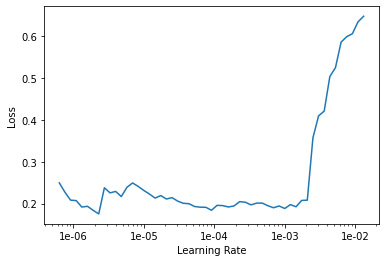

In [13]:
learn.unfreeze()
learn.lr_find()
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [47]:
# Rule of thumb is go with 3e-4 for the 2nd number
# Pick the first number one the graph where the line trends down.
# 3e-5 is roughly halfway between 1e-5 and 1e-4 on a log scale graph
learn.fit_one_cycle(4, max_lr=slice(1e-4,3e-4))
learn.save('stage-2')

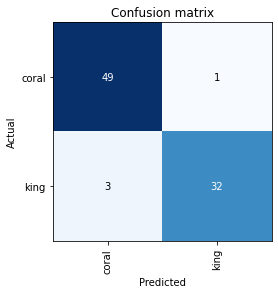

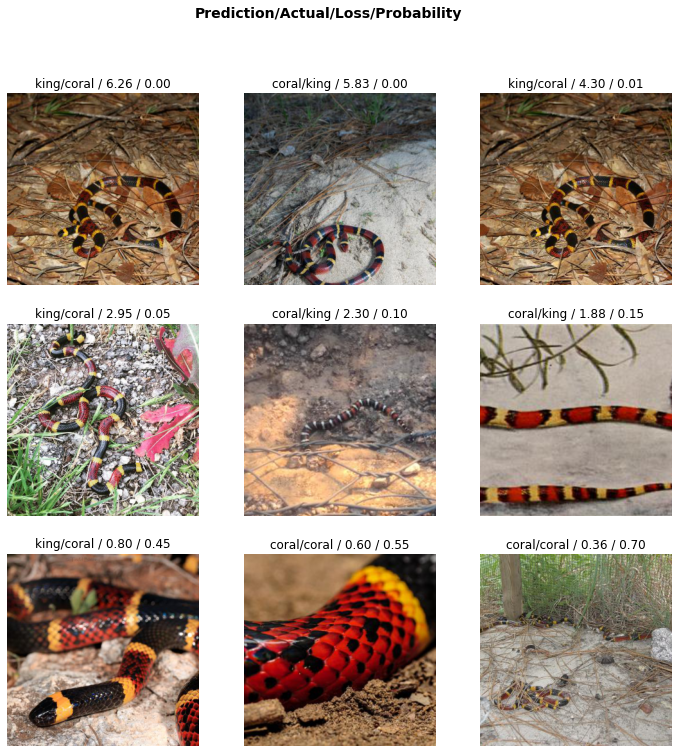

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
inter.plot_top_losses(9)

In [46]:
# Export the trained model to a file.
learn.export(train_path/'trained_model.pkl')